# Logistic Regression with Spotify data

Spotify assigns 13 different musical attributes/features to each song (see this [link](https://developer.spotify.com/console/get-audio-features-track/)). These song attributes, or features, are used to recommend new music to spotify's users. The features are mostly numerical values. Spotify also assigns a **popularity score** based on the total number of clicks for a given song. Alternatively, you can get a sample from [kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features/home).

The question is: can we classify songs as "popular" based on their musical attributes?

# Threshold on continous variables

We can convert any continous variable $y$ into a binary response by defining a **thershold** value. That is, if y > thershold then y = 1, else y = 0. 

In [1]:
# load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
# useful libraries for k-fold CV for cross-sectional data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
""" sklearn-style wrapper for statsmodels regressors """
from sklearn.base import BaseEstimator, RegressorMixin
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(disp=0)
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [3]:
# this is the address where the data is at github
url='https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_2/spotify.csv'

# load it into a data frame
col_names = ['artist', 'track_id', 'track_name', 'acousticness', 'danceability',
             'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 
             'loudness','mode', 'speechiness', 'tempo', 'time_signature', 
             'valence', 'popularity']

# read csv file
df = pd.read_csv(url, delimiter=',', names=col_names, header=1)
print('The data set has {} observations, with {} features each.'.\
      format(df.shape[0],df.shape[1]))

The data set has 130662 observations, with 17 features each.


In [4]:
# so lets definy a threhold for the popularity socre at spotify
threshold = 35

In [5]:
# I am defining a function to plot a density function
def plot_density(df, thershold):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    
    # plot density
    sns.histplot(df['popularity'], color='g', label="Popularity Score",\
                 kde=True, stat="density", linewidth=0, bins=25)\
               .set_title("Distribution of Popularity Scores - Entire Data Set")
    # plot the threshold 
    plt.vlines(threshold, 0, 0.05, colors='r', label='Threshold')
    
    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")
    plt.legend()

    plt.show()

## Density functions

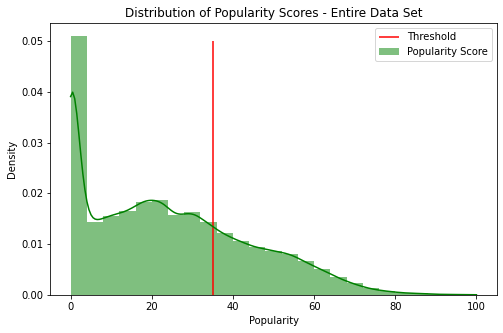

In [6]:
# use the function that we defined above
# and plot the score density together with 
# our threshold to create a binary response y
plot_density(df, threshold)

# K-fold cross-validation
The idea is to use the thersehold on the continous popularity score to derive a binary response variable $y$. Then, using the song features, we classify songs into *popular* or *not popular* using a K-fold cross-validation approach.

In [8]:
# define binary variable
df['pop_bin'] = np.where(df['popularity'] > threshold, 1, 0)

# features to use as predictors/covariates
x = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness'
     ,'liveness','loudness','mode','speechiness','tempo','time_signature',\
     'valence']
y = ['pop_bin']

# get x and y
x = df[x].values
y = df[y].values

# define different number of folds
Ks = [5,10,15,20]
# lets iterate for each fold
for k in Ks:
  kfolds = KFold(n_splits=k, shuffle=True)
  # define the model in statsmodels
  logistic_regression = sm.Logit
  #use the cross_val_score function to fit K models
  scores = cross_val_score(SMWrapper(logistic_regression), x, y, cv=kfolds,\
                           scoring='roc_auc')
  print('CV with {0} folds has an average AUC {1:.6f} with standard deviation\
         {2:.4f}'.format(k,np.mean(scores),np.std(scores)))


CV with 5 folds has an average AUC 0.685612 with standard deviation         0.0015
CV with 10 folds has an average AUC 0.685848 with standard deviation         0.0045
CV with 15 folds has an average AUC 0.685748 with standard deviation         0.0054
CV with 20 folds has an average AUC 0.685797 with standard deviation         0.0062


**Question:** Run the above K-fold CV for K = 5, 10, 15. Comment the results.

**Question:** Add a loop at the top of the above block where you can use different threshold values and repeat the  5-folds cross validation. 

**Tips:** It can be a good idea to start with these two lines:
```
thresholds =[25, 35, 45, 55]
for threshold in thresholds:
```

## Always check carefully number of positve class in the test set


In [9]:
print('Original class ratio {:.4f}'.format(y.sum()/y.shape[0]))

# define different number of folds
Ks = [5]
# lets iterate for each fold
for k in Ks:
  kfolds = KFold(n_splits=k, shuffle=True)
  for train_idx, test_idx in kfolds.split(y):
    print("Number of y=1 in train set {0} (or {1:.4f}) and in test set {2} (or \
    {3:.4f}):".format(np.sum(y[train_idx]),np.sum(y[train_idx])/\
    y[train_idx].shape[0],np.sum(y[test_idx]),np.sum(y[test_idx])/y[test_idx]\
    .shape[0]))
          

Original class ratio 0.2773
Number of y=1 in train set 28828 (or 0.2758) and in test set 7407 (or     0.2834):
Number of y=1 in train set 29003 (or 0.2775) and in test set 7232 (or     0.2767):
Number of y=1 in train set 28963 (or 0.2771) and in test set 7272 (or     0.2783):
Number of y=1 in train set 29071 (or 0.2781) and in test set 7164 (or     0.2741):
Number of y=1 in train set 29075 (or 0.2781) and in test set 7160 (or     0.2740):


**Do you have any comment about the class-balance in the train and test folds??**